# 基于机器学习的原神情感分析

In [7]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import  accuracy_score, precision_score
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
plt.rcParams['font.sans-serif'] = ['SimHei']
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertModel


In [ ]:
# 读取数据
data = pd.read_csv('data/comment_ori.csv')
data

In [3]:
# 模型的性能度量
def performance_test(name,y_test,y_pred):
    # 准确度
    accuracy = accuracy_score(y_test, y_pred)
    # 精确度
    precision = precision_score(y_test, y_pred) 
    # 召回率
    recall = recall_score(y_test, y_pred)
    # F1分数
    f1 = f1_score(y_test, y_pred)
    # AUC值
    roc_auc = roc_auc_score(y_test, y_pred)
    result = {'model':[name],'accuracy':[accuracy],'precision':[precision],
              'recall':[recall],'f1':[f1],'auc':roc_auc}
    result = pd.DataFrame(result)  # 字典转dataframe
    return result

In [10]:
tokenizer = BertTokenizer.from_pretrained("models2/bert_tokenizer")
model = BertModel.from_pretrained("models2/bert-base-chinese")

# 确保使用GPU加速（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [11]:
def get_content_vec(input_text):
    '''获取文本的向量表示'''
    # 使用tokenizer对文本进行编码
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
    inputs.to(device)

    # 使用模型进行推断
    with torch.no_grad():
        outputs = model(**inputs)
        content_vec = outputs.pooler_output[0]
    return content_vec

In [52]:
# 文本向量化
vecs = []
for i in data['commentContent']:
    vec = get_content_vec(i)
    vecs.append(vec)

In [53]:
# 划分数据集
X = torch.stack(vecs).cpu()
y = torch.Tensor(data['score'].values).cpu()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 决策树模型

In [54]:
param_tree = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # 划分标准
    'splitter':['best','random'],
    'max_depth': [1, 2, 4, 8, 16],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 内部节点再划分所需最小样本数
    'min_samples_leaf': [1, 4, 8, 16],
    'max_features': ['auto', 'sqrt', 'log2']}  # 叶子节点最小样本数

In [55]:
# 寻找最佳决策树模型
tree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree, param_grid=param_tree, cv=5,
                           scoring='accuracy',verbose=2)
grid_search.fit(X_train, y_train)
print("最佳参数:", grid_search.best_params_)
best_tree = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_tree = best_tree.predict(X_test)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
[CV] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_features=auto, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] EN

In [56]:
# 保存模型
pickle.dump(best_tree, open(f'models2/decision_tree_bert.dat',"wb"))

# 查看效果
performance_test('decision_tree',y_pred_tree, y_test)

,model,accuracy,precision,recall,f1,auc
0,decision_tree,0.7075,0.841426,0.755102,0.79593,0.65779


### 朴素贝叶斯

In [58]:
gnb = GaussianNB(priors=None, var_smoothing=1e-9)
gnb.fit(X_train,y_train)
y_pred_gnb = gnb.predict(X_test)

In [59]:
pickle.dump(gnb, open(f'models2/naive_bayse_bert.dat',"wb"))

performance_test('naive_bayse_bert',y_pred_gnb, y_test)

,model,accuracy,precision,recall,f1,auc
0,naive_bayse_bert,0.460833,0.244622,0.859611,0.380861,0.612562


### XGBoost

In [60]:
# 定义要调优的超参数网格
param_grid = {
    'eta':[0.01, 0.1,0.2],
    'min_child_weight':[1, 2, 4, 8],
    'max_depth': [2, 4, 8, 16],
    'colsample_bytree': [0.5, 0.8, 1]}

# 初始化XGBoost
xgb_clf = XGBClassifier()

# 使用 GridSearchCV 进行网格搜索
grid_search = GridSearchCV(xgb_clf, param_grid, n_jobs=-1, cv=5,
                           scoring='accuracy',verbose=2)
grid_search.fit(X_train, y_train)

# 打印最佳参数组合和对应的准确率
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数组合的模型进行预测
best_xgb_clf = grid_search.best_estimator_
y_pred_xgb = best_xgb_clf.predict(X_test)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
最佳参数组合: {'colsample_bytree': 0.5, 'eta': 0.1, 'max_depth': 16, 'min_child_weight': 1}


In [65]:
pickle.dump(best_xgb_clf, open(f'models2/xgboost_bert.dat',"wb"))
performance_test('xgboost_bag',y_pred_xgb, y_test)

,model,accuracy,precision,recall,f1,auc
0,xgboost_bag,0.785417,0.902889,0.804491,0.850854,0.764615


### 结果汇总

In [25]:
with open('models/decision_tree.dat', 'rb') as file:
    # 加载模型
    decision_tree = pickle.load(file)

# 使用加载的模型进行预测等操作
y_pred_tree = decision_tree.predict(X_test)

In [62]:
pfms = pd.concat([performance_test('decision_tree_bert',y_pred_tree, y_test), 
                  performance_test('naive_bayse_bert',y_pred_gnb, y_test), 
                  performance_test('xgboost_bert',y_pred_xgb, y_test)])
# 保存结果
pfms.to_csv('data/result_ml_bert.csv', index=None)
pfms

,model,accuracy,precision,recall,f1,auc
0,decision_tree_bert,0.707500,0.841426,0.755102,0.795930,0.657790
0,naive_bayse_bert,0.460833,0.244622,0.859611,0.380861,0.612562
0,xgboost_bert,0.785417,0.902889,0.804491,0.850854,0.764615


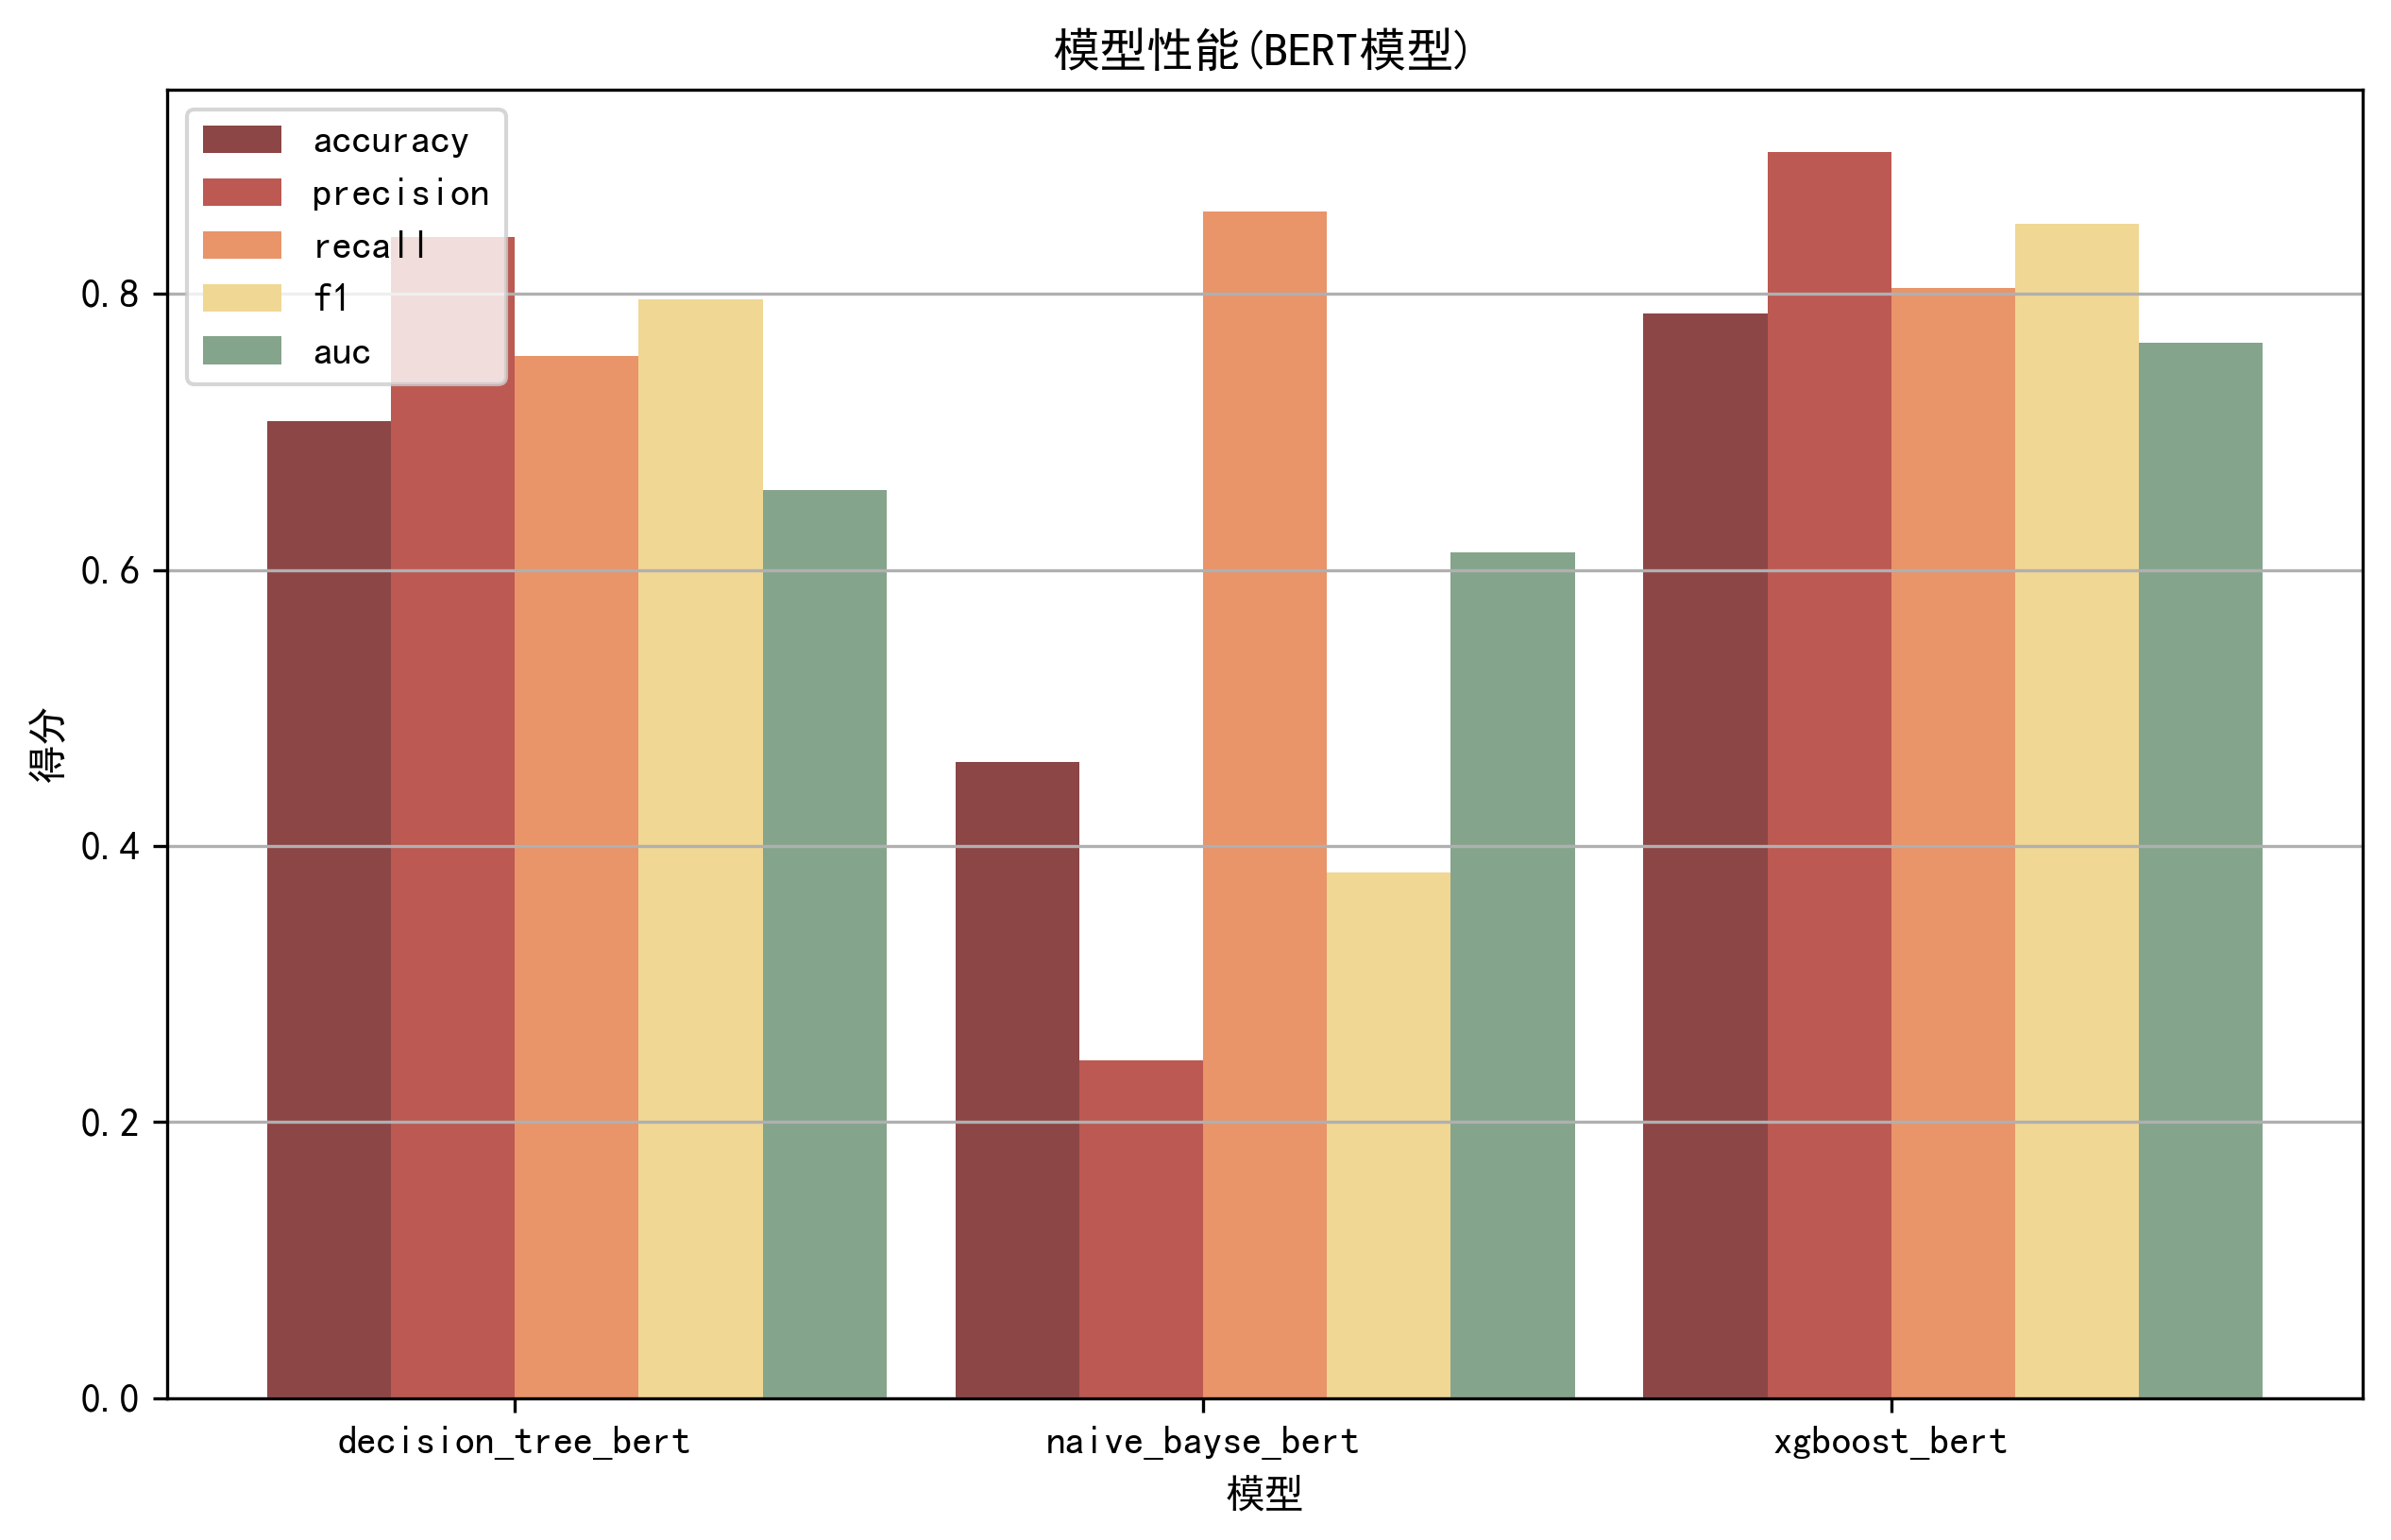

In [63]:
# 模型性能绘图
plt.figure(figsize=(10,6),dpi=300)
categories = ['decision_tree_bert', 'naive_bayse_bert', 'xgboost_bert']
bar_width = 0.18
index = np.arange(len(categories))

plt.bar(index - bar_width, pfms['accuracy'].values, bar_width, label='accuracy',color='#8c4646')
plt.bar(index, pfms['precision'].values, bar_width, label='precision',color='#bc5952')
plt.bar(index + bar_width, pfms['recall'].values, bar_width, label='recall',color='#e99469')
plt.bar(index + bar_width*2, pfms['f1'].values, bar_width, label='f1',color='#f0d794')
plt.bar(index + bar_width*3, pfms['auc'].values, bar_width, label='auc',color='#85a48c')

plt.title('模型性能(BERT模型)')
plt.ylabel('得分')
plt.xlabel('模型')
plt.grid(axis='y')
plt.xticks(index + bar_width / 2, categories)
plt.legend()
plt.show()